# Importing Packages

In [98]:
import pandas as pd
import numpy as np
import json
import joblib
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, mean_squared_error, log_loss, brier_score_loss
from math import sqrt
from imblearn.over_sampling import SMOTE
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Random Forest Classifier

### loading Data and Encoding The classes

In [99]:

# Load your dataset
data = pd.read_csv(r'E:\Assignments\Calibration\Knowledge_base_train - PlayGround.csv')

# Encode the target variable
le = LabelEncoder()
data['class_encoded'] = le.fit_transform(data['class'])
class_names = le.classes_
label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))

# Separate features and target
X = data.drop(['class', 'class_encoded'], axis=1)
y = data['class_encoded']

### Splitting and Oversampling to balance the dataset

In [ ]:
# Splitting data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# SMOTE to balance the classes
smote = SMOTE(random_state=42, k_neighbors=1)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("Original class distribution:", Counter(y_train))
print("Resampled class distribution:", Counter(y_train_resampled))

Original class distribution: Counter({5: 124, 1: 61, 3: 48, 2: 31, 4: 12, 0: 4})
Resampled class distribution: Counter({4: 124, 5: 124, 1: 124, 2: 124, 0: 124, 3: 124})


### Instantiate The Model 

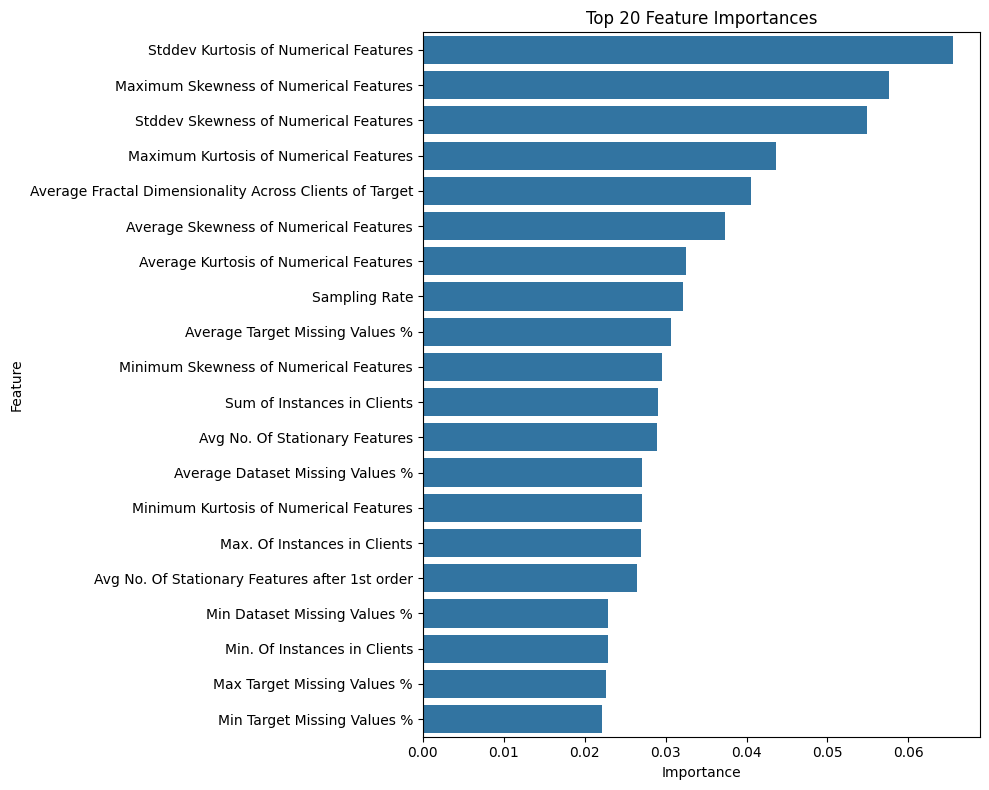

RandomForestClassifier(class_weight='balanced', n_estimators=300,
                       random_state=42)

In [101]:
# Training random forest classifier on the resampled training set
clf = RandomForestClassifier(n_estimators=300, class_weight='balanced', random_state=42)
clf.fit(X_train_resampled, y_train_resampled)

# Feature Importance
importances = clf.feature_importances_
feature_names = X_train.columns
feat_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feat_imp_df = feat_imp_df.sort_values(by='Importance', ascending=False)

# Plotting the top N important features
top_n = 20
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feat_imp_df.head(top_n))
plt.title('Top 20 Feature Importances')
plt.tight_layout()
plt.show()

# Select the top important features (those with importance >= 0.01)
important_features = feat_imp_df[feat_imp_df['Importance'] >= 0.01]['Feature'].tolist()

# Subset the training and test sets to use the most important features
X_train_imp = X_train_resampled[important_features]
X_test_imp = X_test[important_features]

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imp)
X_test_scaled = scaler.transform(X_test_imp)

# The classifier with important features and scaled data
clf.fit(X_train_scaled, y_train_resampled)

### Evaluating the model

In [102]:
# Evaluate the model
y_test_pred = clf.predict(X_test_scaled)
print("Test Set Evaluation with Important Features and Scaled Data:")
print(classification_report(y_test, y_test_pred, target_names=class_names))

# Calculate MSE and RMSE
mse = mean_squared_error(y_test, y_test_pred)
rmse = sqrt(mse)
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

Test Set Evaluation with Important Features and Scaled Data:
                   precision    recall  f1-score   support

     ELASTICNETCV       0.00      0.00      0.00         1
   HUBERREGRESSOR       0.57      0.87      0.68        15
            LASSO       0.50      0.50      0.50         8
        LinearSVR       0.33      0.25      0.29        12
QUANTILEREGRESSOR       1.00      0.33      0.50         3
     XGBRegressor       0.86      0.81      0.83        31

         accuracy                           0.66        70
        macro avg       0.54      0.46      0.47        70
     weighted avg       0.66      0.66      0.64        70

Mean Squared Error (MSE): 1.7857142857142858
Root Mean Squared Error (RMSE): 1.3363062095621219


### The Parsing and desired output function

In [ ]:
def predict_best_algorithms(meta_features_dict):
    output = {}
    for key, meta_features in meta_features_dict.items():
        meta_features_df = pd.DataFrame([meta_features])

        # Making sure that all required features are present
        missing_cols = set(important_features) - set(meta_features_df.columns)
        if missing_cols:
            print(f"Warning: Missing features for instance {key}: {missing_cols}")

            # Fill missing features with mean values
            for col in missing_cols:
                meta_features_df[col] = X_train_resampled[col].mean()

        # Transform the data
        meta_features_df = meta_features_df[important_features]
        meta_features_scaled = scaler.transform(meta_features_df)

        # Predict probabilities
        prob = clf.predict_proba(meta_features_scaled)[0]

        # Create a dictionary of class probabilities to sort and make them float to the round of 2
        prob_dict = dict(zip(class_names, prob))
        sorted_prob_list = sorted(prob_dict.items(), key=lambda item: item[1], reverse=True)
        sorted_prob_dict = {k: round(float(v), 2) for k, v in sorted_prob_list}
        output[key] = sorted_prob_dict
        
    return output

# XGBoost Classifier

### loading Data and Encoding The classes

In [85]:
# Load your dataset
data = pd.read_csv(r'E:\Assignments\Calibration\Knowledge_base_train - PlayGround.csv')

# Encode the target variable
le = LabelEncoder()
data['class_encoded'] = le.fit_transform(data['class'])
class_names = le.classes_
label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))

# Separate features and target
X = data.drop(['class', 'class_encoded'], axis=1)
y = data['class_encoded']

### Splitting and Oversampling to balance the dataset

In [86]:
# Splitting into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# SMOTE to balance the classes
smote = SMOTE(random_state=42, k_neighbors=1)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)


print("Original class distribution:", Counter(y_train))
print("Resampled class distribution:", Counter(y_train_resampled))

Original class distribution: Counter({5: 124, 1: 61, 3: 48, 2: 31, 4: 12, 0: 4})
Resampled class distribution: Counter({4: 124, 5: 124, 1: 124, 2: 124, 0: 124, 3: 124})


### Instantiate The Model 

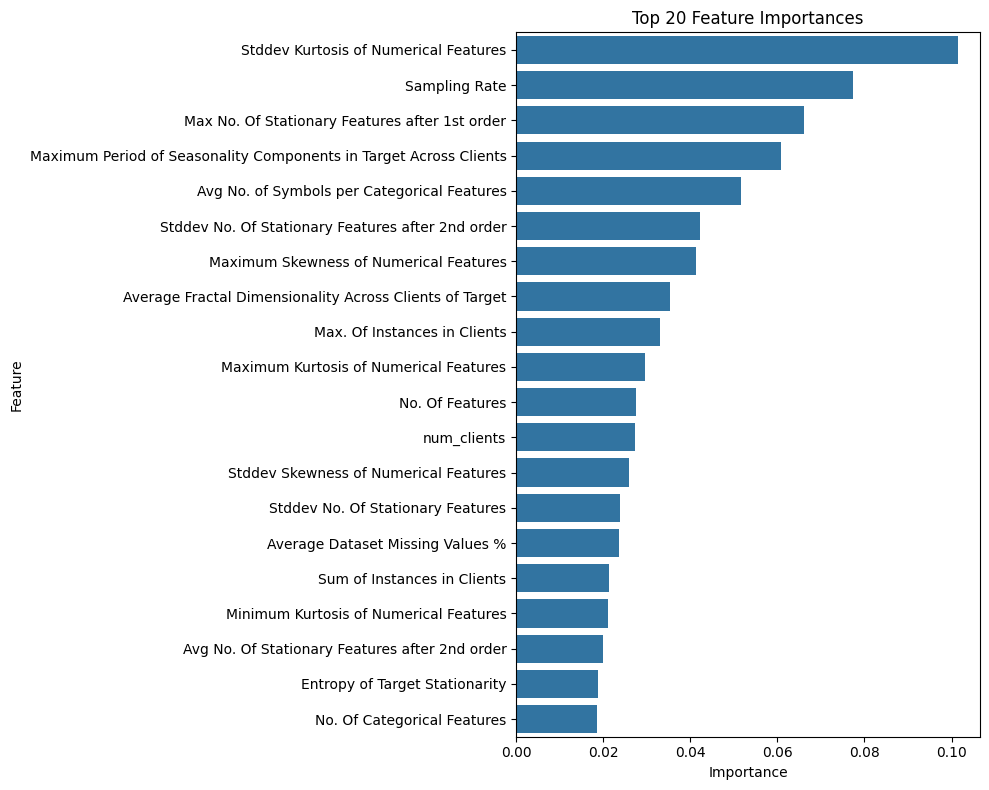

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, objective='multi:softprob', ...)

In [87]:
# The XGBoost classifier
clf = XGBClassifier(
    use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=42
)

# Train the classifier on the resampled training set
clf.fit(X_train_resampled, y_train_resampled)

# Feature Importance
importances = clf.feature_importances_
feature_names = X_train.columns
feat_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feat_imp_df = feat_imp_df.sort_values(by='Importance', ascending=False)

# Plot the top N important features
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feat_imp_df.head(20))
plt.title('Top 20 Feature Importances')
plt.tight_layout()
plt.show()

# Select the top important features (those with importance >= 0.02)
important_features = feat_imp_df[feat_imp_df['Importance'] >= 0.02]['Feature'].tolist()

# Subset the training and test sets to use the most important features
X_train_imp = X_train_resampled[important_features]
X_test_imp = X_test[important_features]

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imp)
X_test_scaled = scaler.transform(X_test_imp)

# The classifier with important features and scaled data
clf.fit(X_train_scaled, y_train_resampled)

### Evaluating the model

In [88]:
# Evaluate the model
y_test_pred = clf.predict(X_test_scaled)
print("Test Set Evaluation with Important Features and Scaled Data:")
print(classification_report(y_test, y_test_pred, target_names=class_names))

# Calculate MSE and RMSE
mse = mean_squared_error(y_test, y_test_pred)
rmse = sqrt(mse)
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

Test Set Evaluation with Important Features and Scaled Data:
                   precision    recall  f1-score   support

     ELASTICNETCV       0.00      0.00      0.00         1
   HUBERREGRESSOR       0.55      0.80      0.65        15
            LASSO       0.57      0.50      0.53         8
        LinearSVR       0.42      0.42      0.42        12
QUANTILEREGRESSOR       0.00      0.00      0.00         3
     XGBRegressor       0.90      0.84      0.87        31

         accuracy                           0.67        70
        macro avg       0.41      0.43      0.41        70
     weighted avg       0.65      0.67      0.66        70

Mean Squared Error (MSE): 1.5571428571428572
Root Mean Squared Error (RMSE): 1.2478553029669974


### The Parsing and desired output function

In [89]:
# Define the function to predict best algorithms for multiple instances
def predict_best_algorithms(meta_features_dict):
    output = {}
    for key, meta_features in meta_features_dict.items():
        meta_features_df = pd.DataFrame([meta_features])

        # Making sure that all required features are present
        missing_cols = set(important_features) - set(meta_features_df.columns)
        if missing_cols:
            print(f"Warning: Missing features for instance {key}: {missing_cols}")
            # Fill missing features with mean values
            for col in missing_cols:
                meta_features_df[col] = X_train_resampled[col].mean()

        # Scale features
        meta_features_df = meta_features_df[important_features]
        meta_features_scaled = scaler.transform(meta_features_df)

        # Predict probabilities
        prob = clf.predict_proba(meta_features_scaled)[0]

        # Create a dictionary of class probabilities to sort and make them float to the round of 2
        prob_dict = dict(zip(class_names, prob))
        sorted_prob_list = sorted(prob_dict.items(), key=lambda item: item[1], reverse=True)
        sorted_prob_dict = {k: round(float(v), 2) for k, v in sorted_prob_list}

        output[key] = sorted_prob_dict
    return output

## Save The feature Importance to be used for the API

In [90]:
# feat_imp_df.to_csv('all_57_feature_importance.csv', index=False)

# Testing the uncalibrated model with inputs

In [ ]:
meta_features_inputs = {
  0: {
    "num_clients": 20,
    "Sum of Instances in Clients": 17280,
    "Max. Of Instances in Clients": 864,
    "Min. Of Instances in Clients": 864,
    "Stddev of Instances in Clients": 0,
    "Average Dataset Missing Values %": 5.05787037,
    "Min Dataset Missing Values %": 3.356481481,
    "Max Dataset Missing Values %": 6.712962963,
    "Stddev Dataset Missing Values %": 1.020948805,
    "Average Target Missing Values %": 5.05787037,
    "Min Target Missing Values %": 3.356481481,
    "Max Target Missing Values %": 6.712962963,
    "Stddev Target Missing Values %": 1.020948805,
    "No. Of Features": 7,
    "No. Of Numerical Features": 7,
    "No. Of Categorical Features": 0,
    "Sampling Rate": 0.166666667,
    "Average Skewness of Numerical Features": 2.471131199,
    "Minimum Skewness of Numerical Features": 3.46E-06,
    "Maximum Skewness of Numerical Features": 5.030777624,
    "Stddev Skewness of Numerical Features": 0.678584581,
    "Average Kurtosis of Numerical Features": 10.94694511,
    "Minimum Kurtosis of Numerical Features": 0.009604812,
    "Maximum Kurtosis of Numerical Features": 31.80358209,
    "Stddev Kurtosis of Numerical Features": 4.069728429,
    "Avg No. of Symbols per Categorical Features": 0,
    "Min. No. Of Symbols per Categorical Features": 0,
    "Max. No. Of Symbols per Categorical Features": 0,
    "Stddev No. Of Symbols per Categorical Features": 0,
    "Avg No. Of Stationary Features": 5.8,
    "Min No. Of Stationary Features": 1,
    "Max No. Of Stationary Features": 7,
    "Stddev No. Of Stationary Features": 1.661324773,
    "Avg No. Of Stationary Features after 1st order": 6.05,
    "Min No. Of Stationary Features after 1st order": 6,
    "Max No. Of Stationary Features after 1st order": 7,
    "Stddev No. Of Stationary Features after 1st order": 0.217944947,
    "Avg No. Of Stationary Features after 2nd order": 7,
    "Min No. Of Stationary Features after 2nd order": 7,
    "Max No. Of Stationary Features after 2nd order": 7,
    "Stddev No. Of Stationary Features after 2nd order": 0,
    "Avg No. Of Significant Lags in Target": 6,
    "Min No. Of Significant Lags in Target": 6,
    "Max No. Of Significant Lags in Target": 6,
    "Stddev No. Of Significant Lags in Target": 0,
    "Avg No. Of Insignificant Lags in Target": 4,
    "Min No. Of Insignificant Lags in Target": 4,
    "Max No. Of Insignificant Lags in Target": 4,
    "Stddev No. Of Insignificant Lags in Target": 0,
    "Avg. No. Of Seasonality Components in Target": 0,
    "Max No. Of Seasonality Components in Target": 0,
    "Min No. Of Seasonality Components in Target": 0,
    "Stddev No. Of Seasonality Components in Target": 0,
    "Average Fractal Dimensionality Across Clients of Target": 0.062240441,
    "Maximum Period of Seasonality Components in Target Across Clients": 0,
    "Minimum Period of Seasonality Components in Target Across Clients": 0,
    "Entropy of Target Stationarity": 0.325082973
  },
  1: {
    "num_clients": 5,
    "Sum of Instances in Clients": 10366,
    "Max. Of Instances in Clients": 2074,
    "Min. Of Instances in Clients": 2073,
    "Stddev of Instances in Clients": 0.4,
    "Average Dataset Missing Values %": 5.026089675,
    "Min Dataset Missing Values %": 4.580520733,
    "Max Dataset Missing Values %": 5.354558611,
    "Stddev Dataset Missing Values %": 0.285912384,
    "Average Target Missing Values %": 5.026089675,
    "Min Target Missing Values %": 4.580520733,
    "Max Target Missing Values %": 5.354558611,
    "Stddev Target Missing Values %": 0.285912384,
    "No. Of Features": 5,
    "No. Of Numerical Features": 4,
    "No. Of Categorical Features": 1,
    "Sampling Rate": 0.166666667,
    "Average Skewness of Numerical Features": 0.345071059,
    "Minimum Skewness of Numerical Features": 0.06704511,
    "Maximum Skewness of Numerical Features": 0.610318716,
    "Stddev Skewness of Numerical Features": 0.000351197,
    "Average Kurtosis of Numerical Features": 0.458174213,
    "Minimum Kurtosis of Numerical Features": 0.1180686,
    "Maximum Kurtosis of Numerical Features": 0.903470342,
    "Stddev Kurtosis of Numerical Features": 0.001118617,
    "Avg No. of Symbols per Categorical Features": 1,
    "Min. No. Of Symbols per Categorical Features": 1,
    "Max. No. Of Symbols per Categorical Features": 1,
    "Stddev No. Of Symbols per Categorical Features": 0,
    "Avg No. Of Stationary Features": 0,
    "Min No. Of Stationary Features": 0,
    "Max No. Of Stationary Features": 0,
    "Stddev No. Of Stationary Features": 0,
    "Avg No. Of Stationary Features after 1st order": 5,
    "Min No. Of Stationary Features after 1st order": 5,
    "Max No. Of Stationary Features after 1st order": 5,
    "Stddev No. Of Stationary Features after 1st order": 0,
    "Avg No. Of Stationary Features after 2nd order": 4,
    "Min No. Of Stationary Features after 2nd order": 4,
    "Max No. Of Stationary Features after 2nd order": 4,
    "Stddev No. Of Stationary Features after 2nd order": 0,
    "Avg No. Of Significant Lags in Target": 2,
    "Min No. Of Significant Lags in Target": 2,
    "Max No. Of Significant Lags in Target": 2,
    "Stddev No. Of Significant Lags in Target": 0,
    "Avg No. Of Insignificant Lags in Target": 0,
    "Min No. Of Insignificant Lags in Target": 0,
    "Max No. Of Insignificant Lags in Target": 0,
    "Stddev No. Of Insignificant Lags in Target": 0,
    "Avg. No. Of Seasonality Components in Target": 0,
    "Max No. Of Seasonality Components in Target": 0,
    "Min No. Of Seasonality Components in Target": 0,
    "Stddev No. Of Seasonality Components in Target": 0,
    "Average Fractal Dimensionality Across Clients of Target": 0.067074035,
    "Maximum Period of Seasonality Components in Target Across Clients": 0,
    "Minimum Period of Seasonality Components in Target Across Clients": 0,
    "Entropy of Target Stationarity": 0
  },
  2: {
    "num_clients": 20,
    "Sum of Instances in Clients": 17280,
    "Max. Of Instances in Clients": 864,
    "Min. Of Instances in Clients": 864,
    "Stddev of Instances in Clients": 0,
    "Average Dataset Missing Values %": 4.947916667,
    "Min Dataset Missing Values %": 3.819444444,
    "Max Dataset Missing Values %": 6.134259259,
    "Stddev Dataset Missing Values %": 0.720828836,
    "Average Target Missing Values %": 4.947916667,
    "Min Target Missing Values %": 3.819444444,
    "Max Target Missing Values %": 6.134259259,
    "Stddev Target Missing Values %": 0.720828836,
    "No. Of Features": 4,
    "No. Of Numerical Features": 4,
    "No. Of Categorical Features": 0,
    "Sampling Rate": 0.166666667,
    "Average Skewness of Numerical Features": 0.423866135,
    "Minimum Skewness of Numerical Features": 0,
    "Maximum Skewness of Numerical Features": 1.727176685,
    "Stddev Skewness of Numerical Features": 0.10836163,
    "Average Kurtosis of Numerical Features": 1.10038508,
    "Minimum Kurtosis of Numerical Features": 0,
    "Maximum Kurtosis of Numerical Features": 6.192696008,
    "Stddev Kurtosis of Numerical Features": 0.675688427,
    "Avg No. of Symbols per Categorical Features": 0.05,
    "Min. No. Of Symbols per Categorical Features": 0,
    "Max. No. Of Symbols per Categorical Features": 1,
    "Stddev No. Of Symbols per Categorical Features": 0,
    "Avg No. Of Stationary Features": 0.75,
    "Min No. Of Stationary Features": 0,
    "Max No. Of Stationary Features": 1,
    "Stddev No. Of Stationary Features": 0.433012702,
    "Avg No. Of Stationary Features after 1st order": 3.05,
    "Min No. Of Stationary Features after 1st order": 3,
    "Max No. Of Stationary Features after 1st order": 4,
    "Stddev No. Of Stationary Features after 1st order": 0.217944947,
    "Avg No. Of Stationary Features after 2nd order": 3.95,
    "Min No. Of Stationary Features after 2nd order": 3,
    "Max No. Of Stationary Features after 2nd order": 4,
    "Stddev No. Of Stationary Features after 2nd order": 0.217944947,
    "Avg No. Of Significant Lags in Target": 2,
    "Min No. Of Significant Lags in Target": 2,
    "Max No. Of Significant Lags in Target": 2,
    "Stddev No. Of Significant Lags in Target": 0,
    "Avg No. Of Insignificant Lags in Target": 0,
    "Min No. Of Insignificant Lags in Target": 0,
    "Max No. Of Insignificant Lags in Target": 0,
    "Stddev No. Of Insignificant Lags in Target": 0,
    "Avg. No. Of Seasonality Components in Target": 0,
    "Max No. Of Seasonality Components in Target": 0,
    "Min No. Of Seasonality Components in Target": 0,
    "Stddev No. Of Seasonality Components in Target": 0,
    "Average Fractal Dimensionality Across Clients of Target": 0.049112819,
    "Maximum Period of Seasonality Components in Target Across Clients": 0,
    "Minimum Period of Seasonality Components in Target Across Clients": 0,
    "Entropy of Target Stationarity": 0
  },
  3: {
    "num_clients": 10,
    "Sum of Instances in Clients": 11520,
    "Max. Of Instances in Clients": 1152,
    "Min. Of Instances in Clients": 1152,
    "Stddev of Instances in Clients": 0,
    "Average Dataset Missing Values %": 5.017361111,
    "Min Dataset Missing Values %": 4.513888889,
    "Max Dataset Missing Values %": 5.555555556,
    "Stddev Dataset Missing Values %": 0.371949397,
    "Average Target Missing Values %": 5.017361111,
    "Min Target Missing Values %": 4.513888889,
    "Max Target Missing Values %": 5.555555556,
    "Stddev Target Missing Values %": 0.371949397,
    "No. Of Features": 5,
    "No. Of Numerical Features": 4,
    "No. Of Categorical Features": 1,
    "Sampling Rate": 0.5,
    "Average Skewness of Numerical Features": 1.927091381,
    "Minimum Skewness of Numerical Features": 3.20E-06,
    "Maximum Skewness of Numerical Features": 3.341013746,
    "Stddev Skewness of Numerical Features": 0.402128206,
    "Average Kurtosis of Numerical Features": 10.10997593,
    "Minimum Kurtosis of Numerical Features": 0.007071951,
    "Maximum Kurtosis of Numerical Features": 16.66736245,
    "Stddev Kurtosis of Numerical Features": 1.249609382,
    "Avg No. of Symbols per Categorical Features": 1,
    "Min. No. Of Symbols per Categorical Features": 1,
    "Max. No. Of Symbols per Categorical Features": 1,
    "Stddev No. Of Symbols per Categorical Features": 0,
    "Avg No. Of Stationary Features": 3.1,
    "Min No. Of Stationary Features": 0,
    "Max No. Of Stationary Features": 5,
    "Stddev No. Of Stationary Features": 1.640121947,
    "Avg No. Of Stationary Features after 1st order": 4.3,
    "Min No. Of Stationary Features after 1st order": 4,
    "Max No. Of Stationary Features after 1st order": 5,
    "Stddev No. Of Stationary Features after 1st order": 0.458257569,
    "Avg No. Of Stationary Features after 2nd order": 5,
    "Min No. Of Stationary Features after 2nd order": 5,
    "Max No. Of Stationary Features after 2nd order": 5,
    "Stddev No. Of Stationary Features after 2nd order": 0,
    "Avg No. Of Significant Lags in Target": 3,
    "Min No. Of Significant Lags in Target": 3,
    "Max No. Of Significant Lags in Target": 3,
    "Stddev No. Of Significant Lags in Target": 0,
    "Avg No. Of Insignificant Lags in Target": 1,
    "Min No. Of Insignificant Lags in Target": 1,
    "Max No. Of Insignificant Lags in Target": 1,
    "Stddev No. Of Insignificant Lags in Target": 0,
    "Avg. No. Of Seasonality Components in Target": 0,
    "Max No. Of Seasonality Components in Target": 0,
    "Min No. Of Seasonality Components in Target": 0,
    "Stddev No. Of Seasonality Components in Target": 0,
    "Average Fractal Dimensionality Across Clients of Target": 0.049175743,
    "Maximum Period of Seasonality Components in Target Across Clients": 0,
    "Minimum Period of Seasonality Components in Target Across Clients": 0,
    "Entropy of Target Stationarity": 0.610864302
  },
  4: {
    "num_clients": 10,
    "Sum of Instances in Clients": 34560,
    "Max. Of Instances in Clients": 3456,
    "Min. Of Instances in Clients": 3456,
    "Stddev of Instances in Clients": 0,
    "Average Dataset Missing Values %": 5.011574074,
    "Min Dataset Missing Values %": 4.571759259,
    "Max Dataset Missing Values %": 5.758101852,
    "Stddev Dataset Missing Values %": 0.373880215,
    "Average Target Missing Values %": 5.011574074,
    "Min Target Missing Values %": 4.571759259,
    "Max Target Missing Values %": 5.758101852,
    "Stddev Target Missing Values %": 0.373880215,
    "No. Of Features": 5,
    "No. Of Numerical Features": 4,
    "No. Of Categorical Features": 1,
    "Sampling Rate": 0.166666667,
    "Average Skewness of Numerical Features": 1.816270269,
    "Minimum Skewness of Numerical Features": 0.00342466,
    "Maximum Skewness of Numerical Features": 4.525716863,
    "Stddev Skewness of Numerical Features": 0.815601008,
    "Average Kurtosis of Numerical Features": 8.191426361,
    "Minimum Kurtosis of Numerical Features": 0.365582068,
    "Maximum Kurtosis of Numerical Features": 23.93733452,
    "Stddev Kurtosis of Numerical Features": 4.665371205,
    "Avg No. of Symbols per Categorical Features": 1,
    "Min. No. Of Symbols per Categorical Features": 1,
    "Max. No. Of Symbols per Categorical Features": 1,
    "Stddev No. Of Symbols per Categorical Features": 0,
    "Avg No. Of Stationary Features": 2.9,
    "Min No. Of Stationary Features": 1,
    "Max No. Of Stationary Features": 5,
    "Stddev No. Of Stationary Features": 1.445683229,
    "Avg No. Of Stationary Features after 1st order": 4.4,
    "Min No. Of Stationary Features after 1st order": 4,
    "Max No. Of Stationary Features after 1st order": 5,
    "Stddev No. Of Stationary Features after 1st order": 0.489897949,
    "Avg No. Of Stationary Features after 2nd order": 5,
    "Min No. Of Stationary Features after 2nd order": 5,
    "Max No. Of Stationary Features after 2nd order": 5,
    "Stddev No. Of Stationary Features after 2nd order": 0,
    "Avg No. Of Significant Lags in Target": 3,
    "Min No. Of Significant Lags in Target": 3,
    "Max No. Of Significant Lags in Target": 3,
    "Stddev No. Of Significant Lags in Target": 0,
    "Avg No. Of Insignificant Lags in Target": 1,
    "Min No. Of Insignificant Lags in Target": 1,
    "Max No. Of Insignificant Lags in Target": 1,
    "Stddev No. Of Insignificant Lags in Target": 0,
    "Avg. No. Of Seasonality Components in Target": 0,
    "Max No. Of Seasonality Components in Target": 0,
    "Min No. Of Seasonality Components in Target": 0,
    "Stddev No. Of Seasonality Components in Target": 0,
    "Average Fractal Dimensionality Across Clients of Target": 0.03839722,
    "Maximum Period of Seasonality Components in Target Across Clients": 0,
    "Minimum Period of Seasonality Components in Target Across Clients": 0,
    "Entropy of Target Stationarity": 0.673011667
  },
  5: {
    "num_clients": 5,
    "Sum of Instances in Clients": 14016,
    "Max. Of Instances in Clients": 2804,
    "Min. Of Instances in Clients": 2803,
    "Stddev of Instances in Clients": 0.4,
    "Average Dataset Missing Values %": 5.087095902,
    "Min Dataset Missing Values %": 4.350927247,
    "Max Dataset Missing Values %": 5.458437389,
    "Stddev Dataset Missing Values %": 0.38523344,
    "Average Target Missing Values %": 5.087095902,
    "Min Target Missing Values %": 4.350927247,
    "Max Target Missing Values %": 5.458437389,
    "Stddev Target Missing Values %": 0.38523344,
    "No. Of Features": 1,
    "No. Of Numerical Features": 1,
    "No. Of Categorical Features": 0,
    "Sampling Rate": 0.5,
    "Average Skewness of Numerical Features": 1.13808709,
    "Minimum Skewness of Numerical Features": 0.005346597,
    "Maximum Skewness of Numerical Features": 2.408352879,
    "Stddev Skewness of Numerical Features": 0,
    "Average Kurtosis of Numerical Features": 2.169825629,
    "Minimum Kurtosis of Numerical Features": 1.165074729,
    "Maximum Kurtosis of Numerical Features": 4.687554701,
    "Stddev Kurtosis of Numerical Features": 0,
    "Avg No. of Symbols per Categorical Features": 0,
    "Min. No. Of Symbols per Categorical Features": 0,
    "Max. No. Of Symbols per Categorical Features": 0,
    "Stddev No. Of Symbols per Categorical Features": 0,
    "Avg No. Of Stationary Features": 0.2,
    "Min No. Of Stationary Features": 0,
    "Max No. Of Stationary Features": 1,
    "Stddev No. Of Stationary Features": 0.4,
    "Avg No. Of Stationary Features after 1st order": 0,
    "Min No. Of Stationary Features after 1st order": 0,
    "Max No. Of Stationary Features after 1st order": 0,
    "Stddev No. Of Stationary Features after 1st order": 0,
    "Avg No. Of Stationary Features after 2nd order": 1,
    "Min No. Of Stationary Features after 2nd order": 1,
    "Max No. Of Stationary Features after 2nd order": 1,
    "Stddev No. Of Stationary Features after 2nd order": 0,
    "Avg No. Of Significant Lags in Target": 0,
    "Min No. Of Significant Lags in Target": 0,
    "Max No. Of Significant Lags in Target": 0,
    "Stddev No. Of Significant Lags in Target": 0,
    "Avg No. Of Insignificant Lags in Target": 0,
    "Min No. Of Insignificant Lags in Target": 0,
    "Max No. Of Insignificant Lags in Target": 0,
    "Stddev No. Of Insignificant Lags in Target": 0,
    "Avg. No. Of Seasonality Components in Target": 0,
    "Max No. Of Seasonality Components in Target": 0,
    "Min No. Of Seasonality Components in Target": 0,
    "Stddev No. Of Seasonality Components in Target": 0,
    "Average Fractal Dimensionality Across Clients of Target": 0.024859313,
    "Maximum Period of Seasonality Components in Target Across Clients": 0,
    "Minimum Period of Seasonality Components in Target Across Clients": 0,
    "Entropy of Target Stationarity": 0.673011667
  },
  6: {
    "num_clients": 5,
    "Sum of Instances in Clients": 10366,
    "Max. Of Instances in Clients": 2074,
    "Min. Of Instances in Clients": 2073,
    "Stddev of Instances in Clients": 0.4,
    "Average Dataset Missing Values %": 4.939263646,
    "Min Dataset Missing Values %": 4.532304725,
    "Max Dataset Missing Values %": 5.258080077,
    "Stddev Dataset Missing Values %": 0.27113993,
    "Average Target Missing Values %": 4.939263646,
    "Min Target Missing Values %": 4.532304725,
    "Max Target Missing Values %": 5.258080077,
    "Stddev Target Missing Values %": 0.27113993,
    "No. Of Features": 5,
    "No. Of Numerical Features": 5,
    "No. Of Categorical Features": 0,
    "Sampling Rate": 0.5,
    "Average Skewness of Numerical Features": 1.058958968,
    "Minimum Skewness of Numerical Features": 3.41E-06,
    "Maximum Skewness of Numerical Features": 2.567418381,
    "Stddev Skewness of Numerical Features": 0.41656627,
    "Average Kurtosis of Numerical Features": 5.458283128,
    "Minimum Kurtosis of Numerical Features": 1.12545846,
    "Maximum Kurtosis of Numerical Features": 11.87216316,
    "Stddev Kurtosis of Numerical Features": 2.084569769,
    "Avg No. of Symbols per Categorical Features": 0,
    "Min. No. Of Symbols per Categorical Features": 0,
    "Max. No. Of Symbols per Categorical Features": 0,
    "Stddev No. Of Symbols per Categorical Features": 0,
    "Avg No. Of Stationary Features": 4,
    "Min No. Of Stationary Features": 4,
    "Max No. Of Stationary Features": 4,
    "Stddev No. Of Stationary Features": 0,
    "Avg No. Of Stationary Features after 1st order": 4.2,
    "Min No. Of Stationary Features after 1st order": 4,
    "Max No. Of Stationary Features after 1st order": 5,
    "Stddev No. Of Stationary Features after 1st order": 0.4,
    "Avg No. Of Stationary Features after 2nd order": 5,
    "Min No. Of Stationary Features after 2nd order": 5,
    "Max No. Of Stationary Features after 2nd order": 5,
    "Stddev No. Of Stationary Features after 2nd order": 0,
    "Avg No. Of Significant Lags in Target": 3,
    "Min No. Of Significant Lags in Target": 3,
    "Max No. Of Significant Lags in Target": 3,
    "Stddev No. Of Significant Lags in Target": 0,
    "Avg No. Of Insignificant Lags in Target": 1,
    "Min No. Of Insignificant Lags in Target": 1,
    "Max No. Of Insignificant Lags in Target": 1,
    "Stddev No. Of Insignificant Lags in Target": 0,
    "Avg. No. Of Seasonality Components in Target": 0,
    "Max No. Of Seasonality Components in Target": 0,
    "Min No. Of Seasonality Components in Target": 0,
    "Stddev No. Of Seasonality Components in Target": 0,
    "Average Fractal Dimensionality Across Clients of Target": 0.30093517,
    "Maximum Period of Seasonality Components in Target Across Clients": 0,
    "Minimum Period of Seasonality Components in Target Across Clients": 0,
    "Entropy of Target Stationarity": 0
  },
  7: {
    "num_clients": 10,
    "Sum of Instances in Clients": 27641,
    "Max. Of Instances in Clients": 2765,
    "Min. Of Instances in Clients": 2764,
    "Stddev of Instances in Clients": 0.3,
    "Average Dataset Missing Values %": 4.967231755,
    "Min Dataset Missing Values %": 4.486251809,
    "Max Dataset Missing Values %": 5.714285714,
    "Stddev Dataset Missing Values %": 0.346594076,
    "Average Target Missing Values %": 4.967231755,
    "Min Target Missing Values %": 4.486251809,
    "Max Target Missing Values %": 5.714285714,
    "Stddev Target Missing Values %": 0.346594076,
    "No. Of Features": 1,
    "No. Of Numerical Features": 1,
    "No. Of Categorical Features": 0,
    "Sampling Rate": 0.166666667,
    "Average Skewness of Numerical Features": 0.248887602,
    "Minimum Skewness of Numerical Features": 1.30E-05,
    "Maximum Skewness of Numerical Features": 1.575047171,
    "Stddev Skewness of Numerical Features": 0,
    "Average Kurtosis of Numerical Features": 1.153904396,
    "Minimum Kurtosis of Numerical Features": 1.04170147,
    "Maximum Kurtosis of Numerical Features": 1.201304115,
    "Stddev Kurtosis of Numerical Features": 0,
    "Avg No. of Symbols per Categorical Features": 0,
    "Min. No. Of Symbols per Categorical Features": 0,
    "Max. No. Of Symbols per Categorical Features": 0,
    "Stddev No. Of Symbols per Categorical Features": 0,
    "Avg No. Of Stationary Features": 0.1,
    "Min No. Of Stationary Features": 0,
    "Max No. Of Stationary Features": 1,
    "Stddev No. Of Stationary Features": 0.3,
    "Avg No. Of Stationary Features after 1st order": 0,
    "Min No. Of Stationary Features after 1st order": 0,
    "Max No. Of Stationary Features after 1st order": 0,
    "Stddev No. Of Stationary Features after 1st order": 0,
    "Avg No. Of Stationary Features after 2nd order": 1,
    "Min No. Of Stationary Features after 2nd order": 1,
    "Max No. Of Stationary Features after 2nd order": 1,
    "Stddev No. Of Stationary Features after 2nd order": 0,
    "Avg No. Of Significant Lags in Target": 0,
    "Min No. Of Significant Lags in Target": 0,
    "Max No. Of Significant Lags in Target": 0,
    "Stddev No. Of Significant Lags in Target": 0,
    "Avg No. Of Insignificant Lags in Target": 0,
    "Min No. Of Insignificant Lags in Target": 0,
    "Max No. Of Insignificant Lags in Target": 0,
    "Stddev No. Of Insignificant Lags in Target": 0,
    "Avg. No. Of Seasonality Components in Target": 0,
    "Max No. Of Seasonality Components in Target": 0,
    "Min No. Of Seasonality Components in Target": 0,
    "Stddev No. Of Seasonality Components in Target": 0,
    "Average Fractal Dimensionality Across Clients of Target": 0.012130566,
    "Maximum Period of Seasonality Components in Target Across Clients": 0,
    "Minimum Period of Seasonality Components in Target Across Clients": 0,
    "Entropy of Target Stationarity": 0.325082973
  }
}

# Load your dataset
data_test = pd.read_csv(r'E:\Assignments\Calibration\Knowledge_base_train - test.csv')

data_test_features = data_test.drop(columns=["class"])

data_test_meta_features = data_test_features.to_dict(orient='index')

test_meta_features = X_test.to_dict(orient='index')

# Get predictions for the unseen test data
unseen_predictions = predict_best_algorithms(test_meta_features)
unseen_predictions = predict_best_algorithms(meta_features_inputs)
unseen_predictions = predict_best_algorithms(data_test_meta_features)

# Print the predictions in a readable format
print("Predictions for Unseen Test Data:")
print(json.dumps(unseen_predictions, indent=2))
print(unseen_predictions)

# To print the first value of each input prediction
for key, value in unseen_predictions.items():
    first_key, first_value = next(iter(value.items()))
    print(f"{first_key}: {first_value}")

Predictions for Unseen Test Data:
{0: {'LinearSVR': 0.36, 'HUBERREGRESSOR': 0.24, 'XGBRegressor': 0.16, 'QUANTILEREGRESSOR': 0.14, 'LASSO': 0.09, 'ELASTICNETCV': 0.0}, 1: {'XGBRegressor': 0.45, 'HUBERREGRESSOR': 0.18, 'LASSO': 0.18, 'LinearSVR': 0.18, 'QUANTILEREGRESSOR': 0.0, 'ELASTICNETCV': 0.0}, 2: {'XGBRegressor': 0.5, 'LinearSVR': 0.2, 'HUBERREGRESSOR': 0.16, 'LASSO': 0.14, 'QUANTILEREGRESSOR': 0.0, 'ELASTICNETCV': 0.0}, 3: {'HUBERREGRESSOR': 0.48, 'XGBRegressor': 0.2, 'LinearSVR': 0.12, 'ELASTICNETCV': 0.1, 'LASSO': 0.07, 'QUANTILEREGRESSOR': 0.02}, 4: {'LinearSVR': 0.36, 'XGBRegressor': 0.24, 'HUBERREGRESSOR': 0.16, 'QUANTILEREGRESSOR': 0.13, 'LASSO': 0.11, 'ELASTICNETCV': 0.0}, 5: {'LASSO': 0.48, 'HUBERREGRESSOR': 0.19, 'LinearSVR': 0.15, 'XGBRegressor': 0.14, 'QUANTILEREGRESSOR': 0.04, 'ELASTICNETCV': 0.0}, 6: {'XGBRegressor': 0.95, 'LinearSVR': 0.02, 'HUBERREGRESSOR': 0.01, 'LASSO': 0.01, 'QUANTILEREGRESSOR': 0.01, 'ELASTICNETCV': 0.0}, 7: {'LinearSVR': 0.49, 'XGBRegressor': 

### Model Calibration

Log Loss: 1.0428962461681495
Classification Report (Calibrated):
                   precision    recall  f1-score   support

     ELASTICNETCV       0.00      0.00      0.00         1
   HUBERREGRESSOR       0.52      0.87      0.65        15
            LASSO       0.50      0.50      0.50         8
        LinearSVR       0.30      0.25      0.27        12
QUANTILEREGRESSOR       0.00      0.00      0.00         3
     XGBRegressor       0.93      0.81      0.86        31

         accuracy                           0.64        70
        macro avg       0.37      0.40      0.38        70
     weighted avg       0.63      0.64      0.62        70



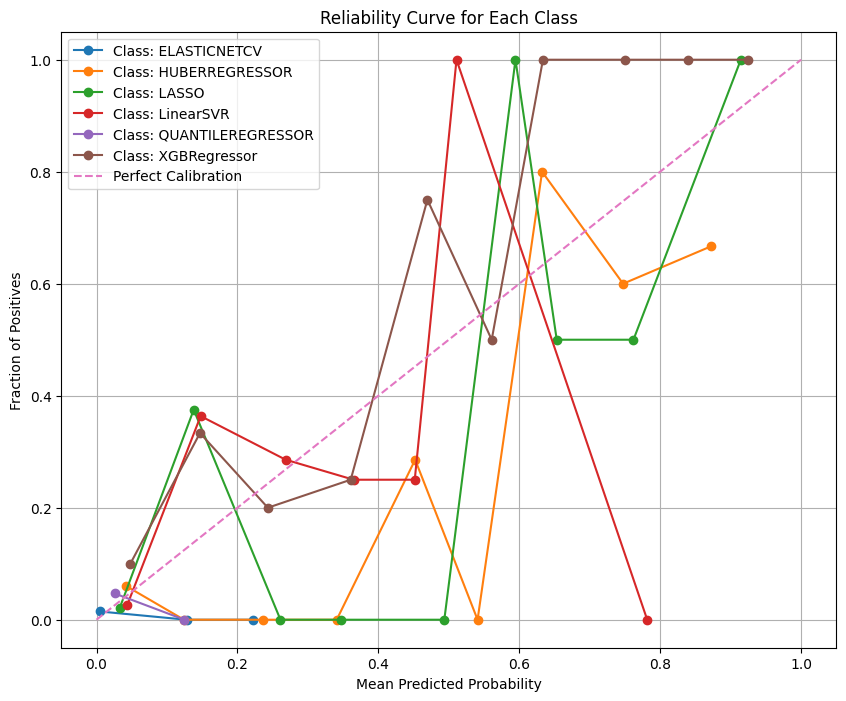

Multiclass Brier Score (average): 0.08296183407313741


In [107]:
# The Calibration
calibrated_clf = CalibratedClassifierCV(clf, method='sigmoid', cv=2)
calibrated_clf.fit(X_train_scaled, y_train_resampled)

# Predict probabilities and evaluate
y_test_pred_proba = calibrated_clf.predict_proba(X_test_scaled)
y_test_pred = calibrated_clf.predict(X_test_scaled)

# Evaluate calibrated probabilities using Log Loss
log_loss_score = log_loss(y_test, y_test_pred_proba)
print(f"Log Loss: {log_loss_score}")

# Classification report
print("Classification Report (Calibrated):")
print(classification_report(y_test, y_test_pred, target_names=class_names))

# Plot reliability curve for each class
plt.figure(figsize=(10, 8))
for i, class_name in enumerate(class_names):
    prob_true, prob_pred = calibration_curve(
        (y_test == i).astype(int), 
        y_test_pred_proba[:, i],  
        n_bins=10
    )
    plt.plot(prob_pred, prob_true, marker='o', label=f'Class: {class_name}')

plt.plot([0, 1], [0, 1], linestyle='--', label='Perfect Calibration')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Reliability Curve for Each Class')
plt.legend()
plt.grid()
plt.show()

# Compute average Brier score across all classes
brier_scores = []
for i in range(len(class_names)):
    brier_score = brier_score_loss(
        (y_test == i).astype(int),  
        y_test_pred_proba[:, i]   
    )
    brier_scores.append(brier_score)

avg_brier_score = np.mean(brier_scores)
print(f"Multiclass Brier Score (average): {avg_brier_score}")


# Saving the Model for the API

In [108]:
# joblib.dump(clf, 'uncalibrated_model.pkl') 

# joblib.dump(calibrated_clf, 'calibrated_model.pkl')

# joblib.dump(scaler, 'scaler.pkl')

# joblib.dump(le, 'label_encoder.pkl')

# The Confidence Assesment

In [109]:
# Predict probabilities using the calibrated classifier
y_test_pred_proba = calibrated_clf.predict_proba(X_test_scaled)

# Get the confidence (max probability) for each prediction
confidence = np.max(y_test_pred_proba, axis=1)

# Get the predicted class
y_test_pred = calibrated_clf.predict(X_test_scaled)

# Combine predictions, confidence, and true labels into a DataFrame
results_df = pd.DataFrame({
    'True Class': y_test,
    'Predicted Class': y_test_pred,
    'Confidence': confidence
})

# Display the first few rows of the results
print("Predictions with Confidence:")
print(results_df.head())

# Classification report for overall evaluation
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred, target_names=class_names))

Predictions with Confidence:
     True Class  Predicted Class  Confidence
343           5                5    0.607283
244           4                1    0.850338
287           5                5    0.917843
174           1                1    0.450518
61            5                5    0.906675

Classification Report:
                   precision    recall  f1-score   support

     ELASTICNETCV       0.00      0.00      0.00         1
   HUBERREGRESSOR       0.52      0.87      0.65        15
            LASSO       0.50      0.50      0.50         8
        LinearSVR       0.30      0.25      0.27        12
QUANTILEREGRESSOR       0.00      0.00      0.00         3
     XGBRegressor       0.93      0.81      0.86        31

         accuracy                           0.64        70
        macro avg       0.37      0.40      0.38        70
     weighted avg       0.63      0.64      0.62        70



### Visualizing the Overall Confidence

#### Random Forest Calibrated Model Plot

Overall Confidence: 0.66


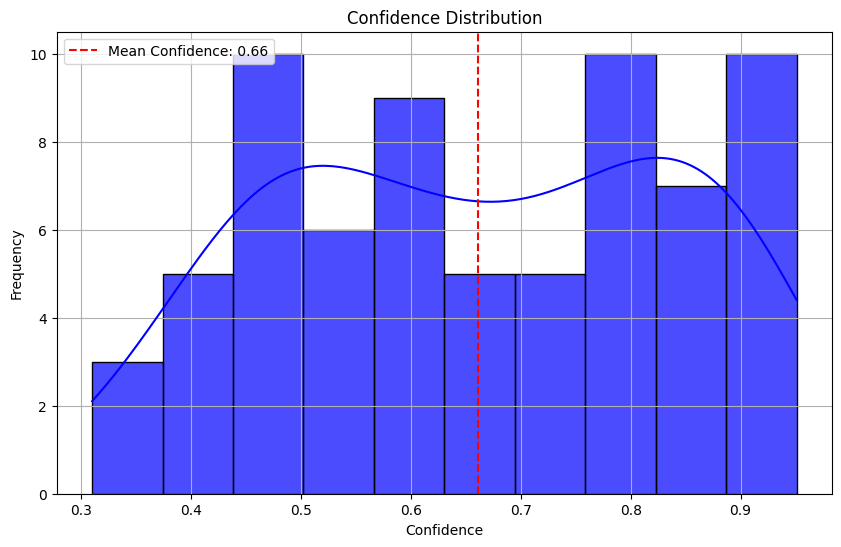

In [110]:
# Predict probabilities using the calibrated classifier
y_test_pred_proba = calibrated_clf.predict_proba(X_test_scaled)

# Get the confidence (max probability) for each prediction
confidence = np.max(y_test_pred_proba, axis=1)

# Get the predicted class
y_test_pred = calibrated_clf.predict(X_test_scaled)

# Combine predictions, confidence, and true labels into a DataFrame
results_df = pd.DataFrame({
    'True Class': y_test,
    'Predicted Class': y_test_pred,
    'Confidence': confidence
})

# Calculate overall confidence (mean of all confidences)
overall_confidence = confidence.mean()
print(f"Overall Confidence: {overall_confidence:.2f}")

# Plot the distribution of confidence scores
plt.figure(figsize=(10, 6))
sns.histplot(confidence, bins=10, kde=True, color='blue', alpha=0.7)
plt.axvline(overall_confidence, color='red', linestyle='--', label=f'Mean Confidence: {overall_confidence:.2f}')
plt.title('Confidence Distribution')
plt.xlabel('Confidence')
plt.ylabel('Frequency')
plt.legend()
plt.grid()
plt.show()


### The Parsing and desired output function for the Calibrated Models

In [111]:
# Define the function to predict best algorithms for multiple instances
def predict_best_algorithms_test(meta_features_dict):
    output = {}
    for key, meta_features in meta_features_dict.items():
        meta_features_df = pd.DataFrame([meta_features])
        # Making Sure that all required features are present
        missing_cols = set(important_features) - set(meta_features_df.columns)
        if missing_cols:
            print(f"Warning: Missing features for instance {key}: {missing_cols}")
            # Fill missing features with mean values 
            for col in missing_cols:
                meta_features_df[col] = X_train_resampled[col].mean()

        # Scale features
        meta_features_df = meta_features_df[important_features]
        meta_features_scaled = scaler.transform(meta_features_df)

        # Predict probabilities
        prob = calibrated_clf.predict_proba(meta_features_scaled)[0]

        # Create a dictionary of class probabilities to sort and make them float to the round of 2
        prob_dict = dict(zip(class_names, prob))
        sorted_prob_list = sorted(prob_dict.items(), key=lambda item: item[1], reverse=True)
        sorted_prob_dict = {k: round(float(v), 2) for k, v in sorted_prob_list}

        output[key] = sorted_prob_dict
    return output

### Calibrated Model Input Test

In [ ]:
meta_features_inputs = {
  0: {
    "num_clients": 20,
    "Sum of Instances in Clients": 17280,
    "Max. Of Instances in Clients": 864,
    "Min. Of Instances in Clients": 864,
    "Stddev of Instances in Clients": 0,
    "Average Dataset Missing Values %": 5.05787037,
    "Min Dataset Missing Values %": 3.356481481,
    "Max Dataset Missing Values %": 6.712962963,
    "Stddev Dataset Missing Values %": 1.020948805,
    "Average Target Missing Values %": 5.05787037,
    "Min Target Missing Values %": 3.356481481,
    "Max Target Missing Values %": 6.712962963,
    "Stddev Target Missing Values %": 1.020948805,
    "No. Of Features": 7,
    "No. Of Numerical Features": 7,
    "No. Of Categorical Features": 0,
    "Sampling Rate": 0.166666667,
    "Average Skewness of Numerical Features": 2.471131199,
    "Minimum Skewness of Numerical Features": 3.46E-06,
    "Maximum Skewness of Numerical Features": 5.030777624,
    "Stddev Skewness of Numerical Features": 0.678584581,
    "Average Kurtosis of Numerical Features": 10.94694511,
    "Minimum Kurtosis of Numerical Features": 0.009604812,
    "Maximum Kurtosis of Numerical Features": 31.80358209,
    "Stddev Kurtosis of Numerical Features": 4.069728429,
    "Avg No. of Symbols per Categorical Features": 0,
    "Min. No. Of Symbols per Categorical Features": 0,
    "Max. No. Of Symbols per Categorical Features": 0,
    "Stddev No. Of Symbols per Categorical Features": 0,
    "Avg No. Of Stationary Features": 5.8,
    "Min No. Of Stationary Features": 1,
    "Max No. Of Stationary Features": 7,
    "Stddev No. Of Stationary Features": 1.661324773,
    "Avg No. Of Stationary Features after 1st order": 6.05,
    "Min No. Of Stationary Features after 1st order": 6,
    "Max No. Of Stationary Features after 1st order": 7,
    "Stddev No. Of Stationary Features after 1st order": 0.217944947,
    "Avg No. Of Stationary Features after 2nd order": 7,
    "Min No. Of Stationary Features after 2nd order": 7,
    "Max No. Of Stationary Features after 2nd order": 7,
    "Stddev No. Of Stationary Features after 2nd order": 0,
    "Avg No. Of Significant Lags in Target": 6,
    "Min No. Of Significant Lags in Target": 6,
    "Max No. Of Significant Lags in Target": 6,
    "Stddev No. Of Significant Lags in Target": 0,
    "Avg No. Of Insignificant Lags in Target": 4,
    "Min No. Of Insignificant Lags in Target": 4,
    "Max No. Of Insignificant Lags in Target": 4,
    "Stddev No. Of Insignificant Lags in Target": 0,
    "Avg. No. Of Seasonality Components in Target": 0,
    "Max No. Of Seasonality Components in Target": 0,
    "Min No. Of Seasonality Components in Target": 0,
    "Stddev No. Of Seasonality Components in Target": 0,
    "Average Fractal Dimensionality Across Clients of Target": 0.062240441,
    "Maximum Period of Seasonality Components in Target Across Clients": 0,
    "Minimum Period of Seasonality Components in Target Across Clients": 0,
    "Entropy of Target Stationarity": 0.325082973
  },
  1: {
    "num_clients": 5,
    "Sum of Instances in Clients": 10366,
    "Max. Of Instances in Clients": 2074,
    "Min. Of Instances in Clients": 2073,
    "Stddev of Instances in Clients": 0.4,
    "Average Dataset Missing Values %": 5.026089675,
    "Min Dataset Missing Values %": 4.580520733,
    "Max Dataset Missing Values %": 5.354558611,
    "Stddev Dataset Missing Values %": 0.285912384,
    "Average Target Missing Values %": 5.026089675,
    "Min Target Missing Values %": 4.580520733,
    "Max Target Missing Values %": 5.354558611,
    "Stddev Target Missing Values %": 0.285912384,
    "No. Of Features": 5,
    "No. Of Numerical Features": 4,
    "No. Of Categorical Features": 1,
    "Sampling Rate": 0.166666667,
    "Average Skewness of Numerical Features": 0.345071059,
    "Minimum Skewness of Numerical Features": 0.06704511,
    "Maximum Skewness of Numerical Features": 0.610318716,
    "Stddev Skewness of Numerical Features": 0.000351197,
    "Average Kurtosis of Numerical Features": 0.458174213,
    "Minimum Kurtosis of Numerical Features": 0.1180686,
    "Maximum Kurtosis of Numerical Features": 0.903470342,
    "Stddev Kurtosis of Numerical Features": 0.001118617,
    "Avg No. of Symbols per Categorical Features": 1,
    "Min. No. Of Symbols per Categorical Features": 1,
    "Max. No. Of Symbols per Categorical Features": 1,
    "Stddev No. Of Symbols per Categorical Features": 0,
    "Avg No. Of Stationary Features": 0,
    "Min No. Of Stationary Features": 0,
    "Max No. Of Stationary Features": 0,
    "Stddev No. Of Stationary Features": 0,
    "Avg No. Of Stationary Features after 1st order": 5,
    "Min No. Of Stationary Features after 1st order": 5,
    "Max No. Of Stationary Features after 1st order": 5,
    "Stddev No. Of Stationary Features after 1st order": 0,
    "Avg No. Of Stationary Features after 2nd order": 4,
    "Min No. Of Stationary Features after 2nd order": 4,
    "Max No. Of Stationary Features after 2nd order": 4,
    "Stddev No. Of Stationary Features after 2nd order": 0,
    "Avg No. Of Significant Lags in Target": 2,
    "Min No. Of Significant Lags in Target": 2,
    "Max No. Of Significant Lags in Target": 2,
    "Stddev No. Of Significant Lags in Target": 0,
    "Avg No. Of Insignificant Lags in Target": 0,
    "Min No. Of Insignificant Lags in Target": 0,
    "Max No. Of Insignificant Lags in Target": 0,
    "Stddev No. Of Insignificant Lags in Target": 0,
    "Avg. No. Of Seasonality Components in Target": 0,
    "Max No. Of Seasonality Components in Target": 0,
    "Min No. Of Seasonality Components in Target": 0,
    "Stddev No. Of Seasonality Components in Target": 0,
    "Average Fractal Dimensionality Across Clients of Target": 0.067074035,
    "Maximum Period of Seasonality Components in Target Across Clients": 0,
    "Minimum Period of Seasonality Components in Target Across Clients": 0,
    "Entropy of Target Stationarity": 0
  },
  2: {
    "num_clients": 20,
    "Sum of Instances in Clients": 17280,
    "Max. Of Instances in Clients": 864,
    "Min. Of Instances in Clients": 864,
    "Stddev of Instances in Clients": 0,
    "Average Dataset Missing Values %": 4.947916667,
    "Min Dataset Missing Values %": 3.819444444,
    "Max Dataset Missing Values %": 6.134259259,
    "Stddev Dataset Missing Values %": 0.720828836,
    "Average Target Missing Values %": 4.947916667,
    "Min Target Missing Values %": 3.819444444,
    "Max Target Missing Values %": 6.134259259,
    "Stddev Target Missing Values %": 0.720828836,
    "No. Of Features": 4,
    "No. Of Numerical Features": 4,
    "No. Of Categorical Features": 0,
    "Sampling Rate": 0.166666667,
    "Average Skewness of Numerical Features": 0.423866135,
    "Minimum Skewness of Numerical Features": 0,
    "Maximum Skewness of Numerical Features": 1.727176685,
    "Stddev Skewness of Numerical Features": 0.10836163,
    "Average Kurtosis of Numerical Features": 1.10038508,
    "Minimum Kurtosis of Numerical Features": 0,
    "Maximum Kurtosis of Numerical Features": 6.192696008,
    "Stddev Kurtosis of Numerical Features": 0.675688427,
    "Avg No. of Symbols per Categorical Features": 0.05,
    "Min. No. Of Symbols per Categorical Features": 0,
    "Max. No. Of Symbols per Categorical Features": 1,
    "Stddev No. Of Symbols per Categorical Features": 0,
    "Avg No. Of Stationary Features": 0.75,
    "Min No. Of Stationary Features": 0,
    "Max No. Of Stationary Features": 1,
    "Stddev No. Of Stationary Features": 0.433012702,
    "Avg No. Of Stationary Features after 1st order": 3.05,
    "Min No. Of Stationary Features after 1st order": 3,
    "Max No. Of Stationary Features after 1st order": 4,
    "Stddev No. Of Stationary Features after 1st order": 0.217944947,
    "Avg No. Of Stationary Features after 2nd order": 3.95,
    "Min No. Of Stationary Features after 2nd order": 3,
    "Max No. Of Stationary Features after 2nd order": 4,
    "Stddev No. Of Stationary Features after 2nd order": 0.217944947,
    "Avg No. Of Significant Lags in Target": 2,
    "Min No. Of Significant Lags in Target": 2,
    "Max No. Of Significant Lags in Target": 2,
    "Stddev No. Of Significant Lags in Target": 0,
    "Avg No. Of Insignificant Lags in Target": 0,
    "Min No. Of Insignificant Lags in Target": 0,
    "Max No. Of Insignificant Lags in Target": 0,
    "Stddev No. Of Insignificant Lags in Target": 0,
    "Avg. No. Of Seasonality Components in Target": 0,
    "Max No. Of Seasonality Components in Target": 0,
    "Min No. Of Seasonality Components in Target": 0,
    "Stddev No. Of Seasonality Components in Target": 0,
    "Average Fractal Dimensionality Across Clients of Target": 0.049112819,
    "Maximum Period of Seasonality Components in Target Across Clients": 0,
    "Minimum Period of Seasonality Components in Target Across Clients": 0,
    "Entropy of Target Stationarity": 0
  },
  3: {
    "num_clients": 10,
    "Sum of Instances in Clients": 11520,
    "Max. Of Instances in Clients": 1152,
    "Min. Of Instances in Clients": 1152,
    "Stddev of Instances in Clients": 0,
    "Average Dataset Missing Values %": 5.017361111,
    "Min Dataset Missing Values %": 4.513888889,
    "Max Dataset Missing Values %": 5.555555556,
    "Stddev Dataset Missing Values %": 0.371949397,
    "Average Target Missing Values %": 5.017361111,
    "Min Target Missing Values %": 4.513888889,
    "Max Target Missing Values %": 5.555555556,
    "Stddev Target Missing Values %": 0.371949397,
    "No. Of Features": 5,
    "No. Of Numerical Features": 4,
    "No. Of Categorical Features": 1,
    "Sampling Rate": 0.5,
    "Average Skewness of Numerical Features": 1.927091381,
    "Minimum Skewness of Numerical Features": 3.20E-06,
    "Maximum Skewness of Numerical Features": 3.341013746,
    "Stddev Skewness of Numerical Features": 0.402128206,
    "Average Kurtosis of Numerical Features": 10.10997593,
    "Minimum Kurtosis of Numerical Features": 0.007071951,
    "Maximum Kurtosis of Numerical Features": 16.66736245,
    "Stddev Kurtosis of Numerical Features": 1.249609382,
    "Avg No. of Symbols per Categorical Features": 1,
    "Min. No. Of Symbols per Categorical Features": 1,
    "Max. No. Of Symbols per Categorical Features": 1,
    "Stddev No. Of Symbols per Categorical Features": 0,
    "Avg No. Of Stationary Features": 3.1,
    "Min No. Of Stationary Features": 0,
    "Max No. Of Stationary Features": 5,
    "Stddev No. Of Stationary Features": 1.640121947,
    "Avg No. Of Stationary Features after 1st order": 4.3,
    "Min No. Of Stationary Features after 1st order": 4,
    "Max No. Of Stationary Features after 1st order": 5,
    "Stddev No. Of Stationary Features after 1st order": 0.458257569,
    "Avg No. Of Stationary Features after 2nd order": 5,
    "Min No. Of Stationary Features after 2nd order": 5,
    "Max No. Of Stationary Features after 2nd order": 5,
    "Stddev No. Of Stationary Features after 2nd order": 0,
    "Avg No. Of Significant Lags in Target": 3,
    "Min No. Of Significant Lags in Target": 3,
    "Max No. Of Significant Lags in Target": 3,
    "Stddev No. Of Significant Lags in Target": 0,
    "Avg No. Of Insignificant Lags in Target": 1,
    "Min No. Of Insignificant Lags in Target": 1,
    "Max No. Of Insignificant Lags in Target": 1,
    "Stddev No. Of Insignificant Lags in Target": 0,
    "Avg. No. Of Seasonality Components in Target": 0,
    "Max No. Of Seasonality Components in Target": 0,
    "Min No. Of Seasonality Components in Target": 0,
    "Stddev No. Of Seasonality Components in Target": 0,
    "Average Fractal Dimensionality Across Clients of Target": 0.049175743,
    "Maximum Period of Seasonality Components in Target Across Clients": 0,
    "Minimum Period of Seasonality Components in Target Across Clients": 0,
    "Entropy of Target Stationarity": 0.610864302
  },
  4: {
    "num_clients": 10,
    "Sum of Instances in Clients": 34560,
    "Max. Of Instances in Clients": 3456,
    "Min. Of Instances in Clients": 3456,
    "Stddev of Instances in Clients": 0,
    "Average Dataset Missing Values %": 5.011574074,
    "Min Dataset Missing Values %": 4.571759259,
    "Max Dataset Missing Values %": 5.758101852,
    "Stddev Dataset Missing Values %": 0.373880215,
    "Average Target Missing Values %": 5.011574074,
    "Min Target Missing Values %": 4.571759259,
    "Max Target Missing Values %": 5.758101852,
    "Stddev Target Missing Values %": 0.373880215,
    "No. Of Features": 5,
    "No. Of Numerical Features": 4,
    "No. Of Categorical Features": 1,
    "Sampling Rate": 0.166666667,
    "Average Skewness of Numerical Features": 1.816270269,
    "Minimum Skewness of Numerical Features": 0.00342466,
    "Maximum Skewness of Numerical Features": 4.525716863,
    "Stddev Skewness of Numerical Features": 0.815601008,
    "Average Kurtosis of Numerical Features": 8.191426361,
    "Minimum Kurtosis of Numerical Features": 0.365582068,
    "Maximum Kurtosis of Numerical Features": 23.93733452,
    "Stddev Kurtosis of Numerical Features": 4.665371205,
    "Avg No. of Symbols per Categorical Features": 1,
    "Min. No. Of Symbols per Categorical Features": 1,
    "Max. No. Of Symbols per Categorical Features": 1,
    "Stddev No. Of Symbols per Categorical Features": 0,
    "Avg No. Of Stationary Features": 2.9,
    "Min No. Of Stationary Features": 1,
    "Max No. Of Stationary Features": 5,
    "Stddev No. Of Stationary Features": 1.445683229,
    "Avg No. Of Stationary Features after 1st order": 4.4,
    "Min No. Of Stationary Features after 1st order": 4,
    "Max No. Of Stationary Features after 1st order": 5,
    "Stddev No. Of Stationary Features after 1st order": 0.489897949,
    "Avg No. Of Stationary Features after 2nd order": 5,
    "Min No. Of Stationary Features after 2nd order": 5,
    "Max No. Of Stationary Features after 2nd order": 5,
    "Stddev No. Of Stationary Features after 2nd order": 0,
    "Avg No. Of Significant Lags in Target": 3,
    "Min No. Of Significant Lags in Target": 3,
    "Max No. Of Significant Lags in Target": 3,
    "Stddev No. Of Significant Lags in Target": 0,
    "Avg No. Of Insignificant Lags in Target": 1,
    "Min No. Of Insignificant Lags in Target": 1,
    "Max No. Of Insignificant Lags in Target": 1,
    "Stddev No. Of Insignificant Lags in Target": 0,
    "Avg. No. Of Seasonality Components in Target": 0,
    "Max No. Of Seasonality Components in Target": 0,
    "Min No. Of Seasonality Components in Target": 0,
    "Stddev No. Of Seasonality Components in Target": 0,
    "Average Fractal Dimensionality Across Clients of Target": 0.03839722,
    "Maximum Period of Seasonality Components in Target Across Clients": 0,
    "Minimum Period of Seasonality Components in Target Across Clients": 0,
    "Entropy of Target Stationarity": 0.673011667
  },
  5: {
    "num_clients": 5,
    "Sum of Instances in Clients": 14016,
    "Max. Of Instances in Clients": 2804,
    "Min. Of Instances in Clients": 2803,
    "Stddev of Instances in Clients": 0.4,
    "Average Dataset Missing Values %": 5.087095902,
    "Min Dataset Missing Values %": 4.350927247,
    "Max Dataset Missing Values %": 5.458437389,
    "Stddev Dataset Missing Values %": 0.38523344,
    "Average Target Missing Values %": 5.087095902,
    "Min Target Missing Values %": 4.350927247,
    "Max Target Missing Values %": 5.458437389,
    "Stddev Target Missing Values %": 0.38523344,
    "No. Of Features": 1,
    "No. Of Numerical Features": 1,
    "No. Of Categorical Features": 0,
    "Sampling Rate": 0.5,
    "Average Skewness of Numerical Features": 1.13808709,
    "Minimum Skewness of Numerical Features": 0.005346597,
    "Maximum Skewness of Numerical Features": 2.408352879,
    "Stddev Skewness of Numerical Features": 0,
    "Average Kurtosis of Numerical Features": 2.169825629,
    "Minimum Kurtosis of Numerical Features": 1.165074729,
    "Maximum Kurtosis of Numerical Features": 4.687554701,
    "Stddev Kurtosis of Numerical Features": 0,
    "Avg No. of Symbols per Categorical Features": 0,
    "Min. No. Of Symbols per Categorical Features": 0,
    "Max. No. Of Symbols per Categorical Features": 0,
    "Stddev No. Of Symbols per Categorical Features": 0,
    "Avg No. Of Stationary Features": 0.2,
    "Min No. Of Stationary Features": 0,
    "Max No. Of Stationary Features": 1,
    "Stddev No. Of Stationary Features": 0.4,
    "Avg No. Of Stationary Features after 1st order": 0,
    "Min No. Of Stationary Features after 1st order": 0,
    "Max No. Of Stationary Features after 1st order": 0,
    "Stddev No. Of Stationary Features after 1st order": 0,
    "Avg No. Of Stationary Features after 2nd order": 1,
    "Min No. Of Stationary Features after 2nd order": 1,
    "Max No. Of Stationary Features after 2nd order": 1,
    "Stddev No. Of Stationary Features after 2nd order": 0,
    "Avg No. Of Significant Lags in Target": 0,
    "Min No. Of Significant Lags in Target": 0,
    "Max No. Of Significant Lags in Target": 0,
    "Stddev No. Of Significant Lags in Target": 0,
    "Avg No. Of Insignificant Lags in Target": 0,
    "Min No. Of Insignificant Lags in Target": 0,
    "Max No. Of Insignificant Lags in Target": 0,
    "Stddev No. Of Insignificant Lags in Target": 0,
    "Avg. No. Of Seasonality Components in Target": 0,
    "Max No. Of Seasonality Components in Target": 0,
    "Min No. Of Seasonality Components in Target": 0,
    "Stddev No. Of Seasonality Components in Target": 0,
    "Average Fractal Dimensionality Across Clients of Target": 0.024859313,
    "Maximum Period of Seasonality Components in Target Across Clients": 0,
    "Minimum Period of Seasonality Components in Target Across Clients": 0,
    "Entropy of Target Stationarity": 0.673011667
  },
  6: {
    "num_clients": 5,
    "Sum of Instances in Clients": 10366,
    "Max. Of Instances in Clients": 2074,
    "Min. Of Instances in Clients": 2073,
    "Stddev of Instances in Clients": 0.4,
    "Average Dataset Missing Values %": 4.939263646,
    "Min Dataset Missing Values %": 4.532304725,
    "Max Dataset Missing Values %": 5.258080077,
    "Stddev Dataset Missing Values %": 0.27113993,
    "Average Target Missing Values %": 4.939263646,
    "Min Target Missing Values %": 4.532304725,
    "Max Target Missing Values %": 5.258080077,
    "Stddev Target Missing Values %": 0.27113993,
    "No. Of Features": 5,
    "No. Of Numerical Features": 5,
    "No. Of Categorical Features": 0,
    "Sampling Rate": 0.5,
    "Average Skewness of Numerical Features": 1.058958968,
    "Minimum Skewness of Numerical Features": 3.41E-06,
    "Maximum Skewness of Numerical Features": 2.567418381,
    "Stddev Skewness of Numerical Features": 0.41656627,
    "Average Kurtosis of Numerical Features": 5.458283128,
    "Minimum Kurtosis of Numerical Features": 1.12545846,
    "Maximum Kurtosis of Numerical Features": 11.87216316,
    "Stddev Kurtosis of Numerical Features": 2.084569769,
    "Avg No. of Symbols per Categorical Features": 0,
    "Min. No. Of Symbols per Categorical Features": 0,
    "Max. No. Of Symbols per Categorical Features": 0,
    "Stddev No. Of Symbols per Categorical Features": 0,
    "Avg No. Of Stationary Features": 4,
    "Min No. Of Stationary Features": 4,
    "Max No. Of Stationary Features": 4,
    "Stddev No. Of Stationary Features": 0,
    "Avg No. Of Stationary Features after 1st order": 4.2,
    "Min No. Of Stationary Features after 1st order": 4,
    "Max No. Of Stationary Features after 1st order": 5,
    "Stddev No. Of Stationary Features after 1st order": 0.4,
    "Avg No. Of Stationary Features after 2nd order": 5,
    "Min No. Of Stationary Features after 2nd order": 5,
    "Max No. Of Stationary Features after 2nd order": 5,
    "Stddev No. Of Stationary Features after 2nd order": 0,
    "Avg No. Of Significant Lags in Target": 3,
    "Min No. Of Significant Lags in Target": 3,
    "Max No. Of Significant Lags in Target": 3,
    "Stddev No. Of Significant Lags in Target": 0,
    "Avg No. Of Insignificant Lags in Target": 1,
    "Min No. Of Insignificant Lags in Target": 1,
    "Max No. Of Insignificant Lags in Target": 1,
    "Stddev No. Of Insignificant Lags in Target": 0,
    "Avg. No. Of Seasonality Components in Target": 0,
    "Max No. Of Seasonality Components in Target": 0,
    "Min No. Of Seasonality Components in Target": 0,
    "Stddev No. Of Seasonality Components in Target": 0,
    "Average Fractal Dimensionality Across Clients of Target": 0.30093517,
    "Maximum Period of Seasonality Components in Target Across Clients": 0,
    "Minimum Period of Seasonality Components in Target Across Clients": 0,
    "Entropy of Target Stationarity": 0
  },
  7: {
    "num_clients": 10,
    "Sum of Instances in Clients": 27641,
    "Max. Of Instances in Clients": 2765,
    "Min. Of Instances in Clients": 2764,
    "Stddev of Instances in Clients": 0.3,
    "Average Dataset Missing Values %": 4.967231755,
    "Min Dataset Missing Values %": 4.486251809,
    "Max Dataset Missing Values %": 5.714285714,
    "Stddev Dataset Missing Values %": 0.346594076,
    "Average Target Missing Values %": 4.967231755,
    "Min Target Missing Values %": 4.486251809,
    "Max Target Missing Values %": 5.714285714,
    "Stddev Target Missing Values %": 0.346594076,
    "No. Of Features": 1,
    "No. Of Numerical Features": 1,
    "No. Of Categorical Features": 0,
    "Sampling Rate": 0.166666667,
    "Average Skewness of Numerical Features": 0.248887602,
    "Minimum Skewness of Numerical Features": 1.30E-05,
    "Maximum Skewness of Numerical Features": 1.575047171,
    "Stddev Skewness of Numerical Features": 0,
    "Average Kurtosis of Numerical Features": 1.153904396,
    "Minimum Kurtosis of Numerical Features": 1.04170147,
    "Maximum Kurtosis of Numerical Features": 1.201304115,
    "Stddev Kurtosis of Numerical Features": 0,
    "Avg No. of Symbols per Categorical Features": 0,
    "Min. No. Of Symbols per Categorical Features": 0,
    "Max. No. Of Symbols per Categorical Features": 0,
    "Stddev No. Of Symbols per Categorical Features": 0,
    "Avg No. Of Stationary Features": 0.1,
    "Min No. Of Stationary Features": 0,
    "Max No. Of Stationary Features": 1,
    "Stddev No. Of Stationary Features": 0.3,
    "Avg No. Of Stationary Features after 1st order": 0,
    "Min No. Of Stationary Features after 1st order": 0,
    "Max No. Of Stationary Features after 1st order": 0,
    "Stddev No. Of Stationary Features after 1st order": 0,
    "Avg No. Of Stationary Features after 2nd order": 1,
    "Min No. Of Stationary Features after 2nd order": 1,
    "Max No. Of Stationary Features after 2nd order": 1,
    "Stddev No. Of Stationary Features after 2nd order": 0,
    "Avg No. Of Significant Lags in Target": 0,
    "Min No. Of Significant Lags in Target": 0,
    "Max No. Of Significant Lags in Target": 0,
    "Stddev No. Of Significant Lags in Target": 0,
    "Avg No. Of Insignificant Lags in Target": 0,
    "Min No. Of Insignificant Lags in Target": 0,
    "Max No. Of Insignificant Lags in Target": 0,
    "Stddev No. Of Insignificant Lags in Target": 0,
    "Avg. No. Of Seasonality Components in Target": 0,
    "Max No. Of Seasonality Components in Target": 0,
    "Min No. Of Seasonality Components in Target": 0,
    "Stddev No. Of Seasonality Components in Target": 0,
    "Average Fractal Dimensionality Across Clients of Target": 0.012130566,
    "Maximum Period of Seasonality Components in Target Across Clients": 0,
    "Minimum Period of Seasonality Components in Target Across Clients": 0,
    "Entropy of Target Stationarity": 0.325082973
  }
}

# Load your dataset
data_test = pd.read_csv(r'E:\Assignments\Calibration\Knowledge_base_train - test.csv')

data_test_features = data_test.drop(columns=["class"])

data_test_meta_features = data_test_features.to_dict(orient='index')

test_meta_features = X_test.to_dict(orient='index')

# Get predictions for the unseen test data for calibrated Model
unseen_predictions = predict_best_algorithms_test(test_meta_features)
unseen_predictions = predict_best_algorithms_test(meta_features_inputs)
unseen_predictions = predict_best_algorithms_test(data_test_meta_features)

# Print the predictions in a readable format
print("Predictions for Unseen Test Data:")
print(json.dumps(unseen_predictions, indent=2))
print(unseen_predictions)

# To print the first value of each input prediction
for key, value in unseen_predictions.items():
    first_key, first_value = next(iter(value.items()))
    print(f"{first_key}: {first_value}")

Predictions for Unseen Test Data:
{0: {'LinearSVR': 0.7, 'XGBRegressor': 0.14, 'HUBERREGRESSOR': 0.09, 'LASSO': 0.06, 'QUANTILEREGRESSOR': 0.02, 'ELASTICNETCV': 0.0}, 1: {'XGBRegressor': 0.73, 'LASSO': 0.11, 'LinearSVR': 0.1, 'HUBERREGRESSOR': 0.04, 'QUANTILEREGRESSOR': 0.02, 'ELASTICNETCV': 0.0}, 2: {'XGBRegressor': 0.64, 'LinearSVR': 0.15, 'HUBERREGRESSOR': 0.1, 'LASSO': 0.08, 'QUANTILEREGRESSOR': 0.02, 'ELASTICNETCV': 0.0}, 3: {'HUBERREGRESSOR': 0.67, 'XGBRegressor': 0.16, 'LinearSVR': 0.05, 'LASSO': 0.04, 'ELASTICNETCV': 0.04, 'QUANTILEREGRESSOR': 0.03}, 4: {'LinearSVR': 0.42, 'XGBRegressor': 0.31, 'HUBERREGRESSOR': 0.13, 'QUANTILEREGRESSOR': 0.08, 'LASSO': 0.06, 'ELASTICNETCV': 0.0}, 5: {'LASSO': 0.73, 'XGBRegressor': 0.12, 'LinearSVR': 0.07, 'HUBERREGRESSOR': 0.05, 'QUANTILEREGRESSOR': 0.02, 'ELASTICNETCV': 0.0}, 6: {'XGBRegressor': 0.95, 'LinearSVR': 0.02, 'QUANTILEREGRESSOR': 0.01, 'HUBERREGRESSOR': 0.01, 'LASSO': 0.01, 'ELASTICNETCV': 0.0}, 7: {'LinearSVR': 0.49, 'XGBRegressor